------------------------

## Model - Unet++ of [segmentation_models.pytorch] + Pytorch Framework 
### Encoder : efficientnet-b3

## Load libraries

In [3]:
import gc
import os
import random
import time
import warnings
warnings.simplefilter("ignore")

#import pdb
#import zipfile
#import pydicom
import albumentations
#from albumentations.pytorch import ToTensorV2
from albumentations import * 
from albumentations.pytorch import ToTensor 
import cv2
import imgaug
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
import tifffile as tiff
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [4]:
#from torchvision import transforms
#import torchvision
#import torchvision.transforms as transforms
import albumentations as A

In [33]:
# Compose = transforms.Compose

## Dataset

##  Set parameters

In [5]:
def set_seed(seed=2**3):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(121)

In [6]:
fold = 0
nfolds = 5
reduce = 4
sz = 256

BATCH_SIZE = 2
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
NUM_WORKERS = 0
SEED = 2020
TH = 0.39  #threshold for positive predictions

DATA = 'test'
LABELS = 'train.csv'
MASKS = 'masks_save'
TRAIN = 'train_save'
df_sample = pd.read_csv('sample_submission.csv')

In [4]:
#256x256 -- 

sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times 
MASKS = 'train_masks.csv'
DATA = 'train'
OUT_TRAIN = 'train_save_now.zip'
OUT_MASKS = 'masks_save_now.zip'

## Util functions

In [7]:

def rle_encode_less_memory(img):
    
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

## Dataset

In [12]:
mean = np.array([0.65527532, 0.49901106, 0.69247992] )
std = np.array([0.25565283, 0.31975344, 0.21533712])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        d = pd.read_csv(LABELS)
#d = d.drop(d[d.id == 'HandE_B005_CL_b_RGB_topright'])
        d = d.drop(d[d.id == 'HandE_B005_CL_b_RGB_topright'].index[0])
        ids = d.id.values
        print(ids)
        kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        print("Printing IDS:",ids)
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('___')[0] in ids]
        print("Printing fnames:",self.fnames)
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)

In [13]:
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

In [14]:
import torch
from torch.utils import data

class MapDataset(data.Dataset):
    def __len__(self):
        return 10

    def __getitem__(self, x):
        return x

class IterableDataset(data.IterableDataset):
    def __len__(self):
        return 10

    def __iter__(self):
        return iter(range(10))


map_loader = data.DataLoader(MapDataset(), batch_size=2)
iterable_loader = data.DataLoader(IterableDataset(), batch_size=2)

In [15]:
ds = HuBMAPDataset(tfms=get_aug())
print(len(ds))
print(ds.fnames)
print(ds.train)
#dl = data.DataLoader(IterableDataset(), batch_size=2)

['CL_HandE_1234_B004_bottomright' 'CL_HandE_1234_B004_topleft'
 'CL_HandE_1234_B004_topright' 'HandE_B005_CL_b_RGB_bottomright'
 'HandE_B005_CL_b_RGB_topleft']
Printing IDS: {'CL_HandE_1234_B004_topleft', 'CL_HandE_1234_B004_topright', 'CL_HandE_1234_B004_bottomright', 'HandE_B005_CL_b_RGB_topleft'}
Printing fnames: ['HandE_B005_CL_b_RGB_topleft___0002.png', 'HandE_B005_CL_b_RGB_topleft___0016.png', 'HandE_B005_CL_b_RGB_topleft___0017.png', 'HandE_B005_CL_b_RGB_topleft___0003.png', 'HandE_B005_CL_b_RGB_topleft___0015.png', 'CL_HandE_1234_B004_topright___0024.png', 'CL_HandE_1234_B004_topright___0018.png', 'CL_HandE_1234_B004_topright___0019.png', 'HandE_B005_CL_b_RGB_topleft___0014.png', 'HandE_B005_CL_b_RGB_topleft___0010.png', 'HandE_B005_CL_b_RGB_topleft___0004.png', 'CL_HandE_1234_B004_topright___0009.png', 'CL_HandE_1234_B004_topright___0021.png', 'CL_HandE_1234_B004_topright___0020.png', 'CL_HandE_1234_B004_topright___0008.png', 'HandE_B005_CL_b_RGB_topleft___0011.png', 'HandE_B0

['CL_HandE_1234_B004_bottomright' 'CL_HandE_1234_B004_topleft'
 'CL_HandE_1234_B004_topright' 'HandE_B005_CL_b_RGB_bottomright'
 'HandE_B005_CL_b_RGB_topleft']
Printing IDS: {'CL_HandE_1234_B004_topleft', 'CL_HandE_1234_B004_topright', 'HandE_B005_CL_b_RGB_bottomright', 'HandE_B005_CL_b_RGB_topleft'}
Printing fnames: ['HandE_B005_CL_b_RGB_topleft___0002.png', 'HandE_B005_CL_b_RGB_topleft___0016.png', 'HandE_B005_CL_b_RGB_topleft___0017.png', 'HandE_B005_CL_b_RGB_topleft___0003.png', 'HandE_B005_CL_b_RGB_topleft___0015.png', 'CL_HandE_1234_B004_topright___0024.png', 'CL_HandE_1234_B004_topright___0018.png', 'CL_HandE_1234_B004_topright___0019.png', 'HandE_B005_CL_b_RGB_topleft___0014.png', 'HandE_B005_CL_b_RGB_topleft___0010.png', 'HandE_B005_CL_b_RGB_topleft___0004.png', 'CL_HandE_1234_B004_topright___0009.png', 'CL_HandE_1234_B004_topright___0021.png', 'CL_HandE_1234_B004_topright___0020.png', 'CL_HandE_1234_B004_topright___0008.png', 'HandE_B005_CL_b_RGB_topleft___0011.png', 'HandE_B

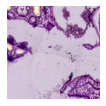

In [27]:
#example of train images with masks
ds = HuBMAPDataset(fold=fold, train=True,tfms=get_aug())
#dl = data.DataLoader(IterableDataset(), batch_size=2)
#num_workers=NUM_WORKERS
dl = torch.utils.data.DataLoader(ds,shuffle=True,num_workers=NUM_WORKERS,batch_size=1)
print(len(dl))
imgs,masks = next(iter(dl))

plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()
    
del ds,dl,imgs,masks

## Model

In [22]:
def get_UnetPlusPlus():
    model =  smp.UnetPlusPlus(
                 encoder_name='efficientnet-b3',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)
    return model

## DiceLoss

Note that this loss represents 1 - DiceLoss.

In [23]:

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

## Training

In [25]:
cv_score = 0
for fold in range(nfolds):
    ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
    ds_v = HuBMAPDataset(fold=fold, train=False)
    dataloader_t = torch.utils.data.DataLoader(ds_t,batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
    dataloader_v = torch.utils.data.DataLoader(ds_t,batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)
    model = get_UnetPlusPlus().to(DEVICE)
    
    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': 1e-3}, 
        {'params': model.encoder.parameters(), 'lr': 1e-3},  
    ])
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(dataloader_t))
    
    diceloss = DiceLoss()
    
    print(f"########FOLD: {fold}##############")
    
    for epoch in tqdm(range(EPOCHS)):
        ###Train
        model.train()
        train_loss = 0
    
        for data in dataloader_t:
            optimizer.zero_grad()
            img, mask = data
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
        
            outputs = model(img)
    
            loss = diceloss(outputs, mask)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
        train_loss /= len(dataloader_t)
        
        print(f"FOLD: {fold}, EPOCH: {epoch + 1}, train_loss: {train_loss}")
        
        ###Validation
        model.eval()
        valid_loss = 0
        
        for data in dataloader_v:
            img, mask = data
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
        
            outputs = model(img)
    
            loss = diceloss(outputs, mask)
        
            valid_loss += loss.item()
        valid_loss /= len(dataloader_v)
        
        print(f"FOLD: {fold}, EPOCH: {epoch + 1}, valid_loss: {valid_loss}")
        
        
    ###Save model
    torch.save(model.state_dict(), f"FOLD{fold}_.pth")
    
    cv_score += valid_loss
    
cv_score = cv_score/nfolds

['CL_HandE_1234_B004_bottomright' 'CL_HandE_1234_B004_topleft'
 'CL_HandE_1234_B004_topright' 'HandE_B005_CL_b_RGB_bottomright'
 'HandE_B005_CL_b_RGB_topleft']
Printing IDS: {'CL_HandE_1234_B004_topleft', 'CL_HandE_1234_B004_topright', 'CL_HandE_1234_B004_bottomright', 'HandE_B005_CL_b_RGB_topleft'}
Printing fnames: ['HandE_B005_CL_b_RGB_topleft___0002.png', 'HandE_B005_CL_b_RGB_topleft___0016.png', 'HandE_B005_CL_b_RGB_topleft___0017.png', 'HandE_B005_CL_b_RGB_topleft___0003.png', 'HandE_B005_CL_b_RGB_topleft___0015.png', 'CL_HandE_1234_B004_topright___0024.png', 'CL_HandE_1234_B004_topright___0018.png', 'CL_HandE_1234_B004_topright___0019.png', 'HandE_B005_CL_b_RGB_topleft___0014.png', 'HandE_B005_CL_b_RGB_topleft___0010.png', 'HandE_B005_CL_b_RGB_topleft___0004.png', 'CL_HandE_1234_B004_topright___0009.png', 'CL_HandE_1234_B004_topright___0021.png', 'CL_HandE_1234_B004_topright___0020.png', 'CL_HandE_1234_B004_topright___0008.png', 'HandE_B005_CL_b_RGB_topleft___0011.png', 'HandE_B0

  0%|          | 0/10 [00:00<?, ?it/s]

FOLD: 0, EPOCH: 1, train_loss: 0.8500821707041367
FOLD: 0, EPOCH: 1, valid_loss: 0.9028026357941006
FOLD: 0, EPOCH: 2, train_loss: 0.8113205977108168
FOLD: 0, EPOCH: 2, valid_loss: 0.9149496697861216
FOLD: 0, EPOCH: 3, train_loss: 0.7716972387355306
FOLD: 0, EPOCH: 3, valid_loss: 0.904011484073556
FOLD: 0, EPOCH: 4, train_loss: 0.7042152648386748
FOLD: 0, EPOCH: 4, valid_loss: 0.889623171609381
FOLD: 0, EPOCH: 5, train_loss: 0.6532554717167564
FOLD: 0, EPOCH: 5, valid_loss: 0.8779418740583502
FOLD: 0, EPOCH: 6, train_loss: 0.6366845252721206
FOLD: 0, EPOCH: 6, valid_loss: 0.7509802035663439
FOLD: 0, EPOCH: 7, train_loss: 0.5926966654217761
FOLD: 0, EPOCH: 7, valid_loss: 0.5508129855860835
FOLD: 0, EPOCH: 8, train_loss: 0.5776682638603708
FOLD: 0, EPOCH: 8, valid_loss: 0.5357959879481274
FOLD: 0, EPOCH: 9, train_loss: 0.5436433501865553
FOLD: 0, EPOCH: 9, valid_loss: 0.5663680576759836
FOLD: 0, EPOCH: 10, train_loss: 0.5343406433644502
FOLD: 0, EPOCH: 10, valid_loss: 0.558415113583855
[

  0%|          | 0/10 [00:00<?, ?it/s]

FOLD: 1, EPOCH: 1, train_loss: 0.8690102666616439
FOLD: 1, EPOCH: 1, valid_loss: 0.9209140673279762
FOLD: 1, EPOCH: 2, train_loss: 0.826978300511837
FOLD: 1, EPOCH: 2, valid_loss: 0.9186007007956505
FOLD: 1, EPOCH: 3, train_loss: 0.8225764125585556
FOLD: 1, EPOCH: 3, valid_loss: 0.9208853945136071
FOLD: 1, EPOCH: 4, train_loss: 0.7886704459786416
FOLD: 1, EPOCH: 4, valid_loss: 0.916913528740406
FOLD: 1, EPOCH: 5, train_loss: 0.7676811531186104
FOLD: 1, EPOCH: 5, valid_loss: 0.9201241746544838
FOLD: 1, EPOCH: 6, train_loss: 0.7092205911874772
FOLD: 1, EPOCH: 6, valid_loss: 0.9209584534168244
FOLD: 1, EPOCH: 7, train_loss: 0.6694755911827087
FOLD: 1, EPOCH: 7, valid_loss: 0.8762943595647812
FOLD: 1, EPOCH: 8, train_loss: 0.6518570765852928
FOLD: 1, EPOCH: 8, valid_loss: 0.7559558570384979
FOLD: 1, EPOCH: 9, train_loss: 0.6182108581066131
FOLD: 1, EPOCH: 9, valid_loss: 0.7259458810091018
FOLD: 1, EPOCH: 10, train_loss: 0.6255425870418548
FOLD: 1, EPOCH: 10, valid_loss: 0.698564738035202
[

  0%|          | 0/10 [00:00<?, ?it/s]

FOLD: 2, EPOCH: 1, train_loss: 0.8359045575304729
FOLD: 2, EPOCH: 1, valid_loss: 0.9617947572615089
FOLD: 2, EPOCH: 2, train_loss: 0.7552716630261119
FOLD: 2, EPOCH: 2, valid_loss: 0.9002735672927484
FOLD: 2, EPOCH: 3, train_loss: 0.7807519799325524
FOLD: 2, EPOCH: 3, valid_loss: 0.9007676287395198
FOLD: 2, EPOCH: 4, train_loss: 0.7154061009244221
FOLD: 2, EPOCH: 4, valid_loss: 0.8940205094290943
FOLD: 2, EPOCH: 5, train_loss: 0.6157332833220319
FOLD: 2, EPOCH: 5, valid_loss: 0.8965174439476757
FOLD: 2, EPOCH: 6, train_loss: 0.5883065462112427
FOLD: 2, EPOCH: 6, valid_loss: 0.701378056188909
FOLD: 2, EPOCH: 7, train_loss: 0.5740677292754011
FOLD: 2, EPOCH: 7, valid_loss: 0.6425786381814538
FOLD: 2, EPOCH: 8, train_loss: 0.5247707977527525
FOLD: 2, EPOCH: 8, valid_loss: 0.5586438295317859
FOLD: 2, EPOCH: 9, train_loss: 0.5196093844204415
FOLD: 2, EPOCH: 9, valid_loss: 0.5536972647759972
FOLD: 2, EPOCH: 10, train_loss: 0.5113066129568147
FOLD: 2, EPOCH: 10, valid_loss: 0.5466506873689047

  0%|          | 0/10 [00:00<?, ?it/s]

FOLD: 3, EPOCH: 1, train_loss: 0.8185679752652238
FOLD: 3, EPOCH: 1, valid_loss: 0.8967496592824052
FOLD: 3, EPOCH: 2, train_loss: 0.8114934970692891
FOLD: 3, EPOCH: 2, valid_loss: 0.8965911734394911
FOLD: 3, EPOCH: 3, train_loss: 0.7746294053589425
FOLD: 3, EPOCH: 3, valid_loss: 0.9053056690751052
FOLD: 3, EPOCH: 4, train_loss: 0.7145495618261942
FOLD: 3, EPOCH: 4, valid_loss: 0.8973133462231334
FOLD: 3, EPOCH: 5, train_loss: 0.6951288857111116
FOLD: 3, EPOCH: 5, valid_loss: 0.8862374454009824
FOLD: 3, EPOCH: 6, train_loss: 0.6147293535674491
FOLD: 3, EPOCH: 6, valid_loss: 0.7372056420256452
FOLD: 3, EPOCH: 7, train_loss: 0.5699058247775566
FOLD: 3, EPOCH: 7, valid_loss: 0.6114333926177606
FOLD: 3, EPOCH: 8, train_loss: 0.5556474502493696
FOLD: 3, EPOCH: 8, valid_loss: 0.5437004449890881
FOLD: 3, EPOCH: 9, train_loss: 0.5312206439855622
FOLD: 3, EPOCH: 9, valid_loss: 0.5238645527420974
FOLD: 3, EPOCH: 10, train_loss: 0.5369952408278861
FOLD: 3, EPOCH: 10, valid_loss: 0.543273838554940

  0%|          | 0/10 [00:00<?, ?it/s]

FOLD: 4, EPOCH: 1, train_loss: 0.8465065986682208
FOLD: 4, EPOCH: 1, valid_loss: 0.9092509868817452
FOLD: 4, EPOCH: 2, train_loss: 0.7664016042000208
FOLD: 4, EPOCH: 2, valid_loss: 0.9078788742040976
FOLD: 4, EPOCH: 3, train_loss: 0.7175790209036607
FOLD: 4, EPOCH: 3, valid_loss: 0.9075001569894644
FOLD: 4, EPOCH: 4, train_loss: 0.6239249736834795
FOLD: 4, EPOCH: 4, valid_loss: 0.9077130265724964
FOLD: 4, EPOCH: 5, train_loss: 0.6089655344302838
FOLD: 4, EPOCH: 5, valid_loss: 0.8026819198559492
FOLD: 4, EPOCH: 6, train_loss: 0.5586035633698488
FOLD: 4, EPOCH: 6, valid_loss: 0.7018916209538778
FOLD: 4, EPOCH: 7, train_loss: 0.5278085561899039
FOLD: 4, EPOCH: 7, valid_loss: 0.5360491474469503
FOLD: 4, EPOCH: 8, train_loss: 0.5090063076752883
FOLD: 4, EPOCH: 8, valid_loss: 0.5121600215251629
FOLD: 4, EPOCH: 9, train_loss: 0.5016083121299744
FOLD: 4, EPOCH: 9, valid_loss: 0.5112476623975314
FOLD: 4, EPOCH: 10, train_loss: 0.49729455587191457
FOLD: 4, EPOCH: 10, valid_loss: 0.50660206568546

In [26]:
print(f"CV score is: {cv_score}")

CV score is: 0.5707012886456739


## Testing continued in part 3.
## Thank you!

### Train & Validation plots - 5 folds - 10 epoch 

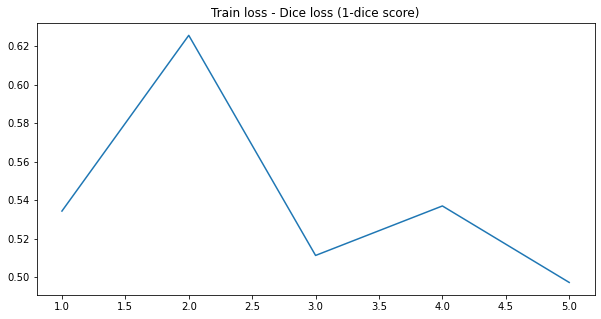

In [37]:
#after each fold - final train & valid loss plots
train_loss = [0.5343406433644502,0.6255425870418548,0.5113066129568147,0.5369952408278861,0.49729455587191457]
valid_loss = [0.558415113583855,0.698564738035202,0.5466506873689047,0.5432738385549406,0.5066020656854678]
folds_ = [1,2,3,4,5]

plt.figure(figsize=(10,5))
#train_loss_val = np.arange(len(train_loss))
plt.plot(folds_,train_loss)
plt.title('Train loss - Dice loss (1-dice score)')
plt.show()

#plt.figure(figsize=(10,5))
#n_e = np.arange(len(dice_list))
#plt.plot(n_e, dice_list)
#plt.title('Train diece ')

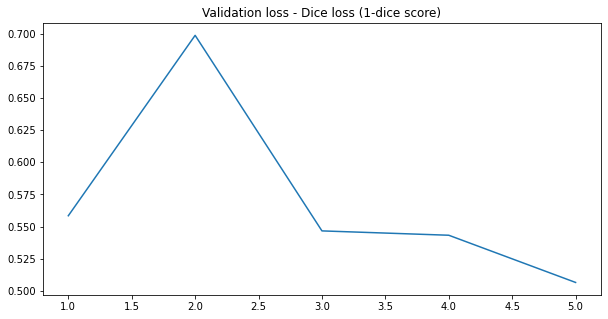

In [36]:
plt.figure(figsize=(10,5))
plt.plot(folds_,valid_loss)
plt.title('Validation loss - Dice loss (1-dice score)')
plt.show()